In [1]:
!nvidia-smi

Thu Mar  9 15:07:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  Off  | 00000000:41:00.0 Off |                    0 |
| N/A   33C    P0    36W / 250W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Imports

In [2]:
# !pip install -q tensorflow==2.11.0

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers.experimental import AdamW
from typing import Tuple
from matplotlib import pyplot as plt

# Set seed for reproducibility.
tf.keras.utils.set_random_seed(42)

2023-03-09 15:07:57.338425: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-09 15:07:58.023480: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/compat/lib.real:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-09 15:07:58.023565: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBR

In [4]:
print(tf.__version__)

2.11.0


# Configurations

In [5]:
# DATA
TRAIN_SLICE = 40000
BATCH_SIZE = 2048
BUFFER_SIZE = BATCH_SIZE*2
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (32, 32, 3)
IMAGE_SIZE = 48
NUM_CLASSES = 10

# OPTIMIZER
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4

# TRAINING
EPOCHS = 50

# MODEL
PATCH_SIZE = 4
EMBED_DIM = 64
CHUNK_SIZE = 8
R = 2
NUM_LAYERS = 6
FFN_DROP = 0.1
ATTN_DROP = 0.1
NUM_HEADS = 1

# Datasets

In [6]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
(x_train, y_train), (x_val, y_val) = (
    (x_train[:TRAIN_SLICE], y_train[:TRAIN_SLICE]),
    (x_train[TRAIN_SLICE:], y_train[TRAIN_SLICE:]),
)

In [7]:
# Build the `train` augmentation pipeline.
train_aug = keras.Sequential(
    [
        layers.Rescaling(1 / 255.0),
        layers.Resizing(INPUT_SHAPE[0] + 20, INPUT_SHAPE[0] + 20),
        layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip("horizontal"),
    ],
    name="train_data_augmentation",
)

# Build the `val` and `test` data pipeline.
test_aug = keras.Sequential(
    [
        layers.Rescaling(1 / 255.0),
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    ],
    name="test_data_augmentation",
)

2023-03-09 15:08:00.822715: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-09 15:08:01.068413: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38433 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0


In [8]:
def train_map_fn(image, label):
    return train_aug(image), label

def test_map_fn(image, label):
    return test_aug(image), label

In [9]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = (
    train_ds.map(
        train_map_fn, num_parallel_calls=AUTO
    )
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = (
    val_ds.map(
        test_map_fn, num_parallel_calls=AUTO
    )
    .batch(BATCH_SIZE, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = (
    test_ds.map(
        test_map_fn, num_parallel_calls=AUTO
    )
    .batch(BATCH_SIZE, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

In [10]:
for image, label in train_ds.take(1):
    print(image.shape)
    print(label.shape)

(2048, 48, 48, 3)
(2048, 1)


# PatchEmbedding

In [11]:
class PatchEmbed(layers.Layer):
    """Image patch embedding layer.

    Args:
        image_size (Tuple[int]): Input image resolution.
        patch_size (Tuple[int]): Patch spatial resolution.
        embed_dim (int): Embedding dimension.
        add_pos_info (bool): Whether to add positional information to tokens.
    """

    def __init__(
        self,
        image_size: Tuple[int] = (48, 48),
        patch_size: Tuple[int] = (4, 4),
        embed_dim: int = 32,
        chunk_size: int = 8,
        **kwargs,
    ):
        super().__init__(**kwargs)
        patch_resolution = [
            image_size[0] // patch_size[0],
            image_size[1] // patch_size[1],
        ]
        self.image_size = image_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.patch_resolution = patch_resolution
        self.num_patches = patch_resolution[0] * patch_resolution[1]
        self.proj = layers.Conv2D(
            filters=embed_dim, kernel_size=patch_size, strides=patch_size
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))
        self.position_embedding = layers.Embedding(
            input_dim=self.num_patches, output_dim=embed_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)
        self.norm = keras.layers.LayerNormalization(epsilon=1e-5)
        self.chunking_layer = layers.Reshape(
            target_shape=(self.num_patches//chunk_size, chunk_size, embed_dim)
        )

    def call(self, x: tf.Tensor) -> Tuple[tf.Tensor, int, int, int]:
        """Patchifies the image, converts into tokens and adds pos information.

        Args:
            x: Tensor of shape (B, H, W, C)

        Returns:
            A tuple of the processed tensor, height of the projected
            feature map, width of the projected feature map, number
            of channels of the projected feature map.
        """
        # Project the inputs.
        x = self.proj(x)
        x = self.flatten(x)
        x = x + self.position_embedding(self.positions)

        # B, H, W, C -> B, H*W, C
        x = self.norm(x)

        # Chunk the tokens in K
        x = self.chunking_layer(x)

        return x

# FFN

In [12]:
class FeedForwardNetwork(layers.Layer):
    """Feed Forward Network.

    Args:
        dims (`int`): Dimension of the FFN.
        dropout (`float`): Dropout probability of FFN.
    """

    def __init__(self, dims: int, dropout: float = 0.1, **kwargs):
        super().__init__(**kwargs)
        self.ffn = keras.Sequential(
            [
                layers.Dense(units=4*dims, activation=tf.nn.gelu),
                layers.Dense(units=dims),
                layers.Dropout(rate=dropout),
            ]
        )
        self.add = layers.Add()
        self.layernorm = layers.LayerNormalization(epsilon=1e-5)

    def call(self, inputs: tf.Tensor):
        x = self.layernorm(inputs)
        x = self.add([inputs, self.ffn(x)])
        return x

# Attention

In [13]:
class BaseAttention(layers.Layer):
    """The base attention module.
    
    Args:
        num_heads (`int`): Number of attention heads.
        key_dim (`int`): Size of each attention head for query and key.
        dropout (`float`): Dropout probability for Attention Module.
    
    """

    def __init__(self, num_heads: int, key_dim: int, dropout: float = 0.1, **kwargs):
        super().__init__(**kwargs)
        self.mha = layers.MultiHeadAttention(num_heads, key_dim, dropout=dropout)
        self.q_layernorm = layers.LayerNormalization(epsilon=1e-5)
        self.k_layernorm = layers.LayerNormalization(epsilon=1e-5)
        self.v_layernorm = layers.LayerNormalization(epsilon=1e-5)
        self.add = layers.Add()

    def call(self, input_query: tf.Tensor, key: tf.Tensor, value: tf.Tensor):
        query = self.q_layernorm(input_query)
        key = self.k_layernorm(key)
        value = self.v_layernorm(value)
        (attn_outs, attn_scores) = self.mha(
            query=query,
            key=key,
            value=value,
            return_attention_scores=True,
        )
        self.attn_scores = attn_scores
        x = self.add([input_query, attn_outs])
        return x

In [14]:
class AttentionWithFFN(layers.Layer):
    """Self-attention module with FFN

    Args:
        ffn_dims (`int`): Number of units in FFN.
        ffn_dropout (`float`): Dropout probability for FFN.
        num_heads (`int`): Number of attention heads.
        key_dim (`int`): Size of each attention head for query and key.
        attn_dropout (`float`): Dropout probability for attention module.
    """

    def __init__(
        self,
        ffn_dims: int = 128,
        ffn_dropout: float = 0.1, 
        num_heads: int = 4,
        key_dim: int = 256,
        attn_dropout: float = 0.1,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.attention = BaseAttention(num_heads, key_dim, attn_dropout, name="BaseAttention")
        self.ffn = FeedForwardNetwork(ffn_dims, ffn_dropout, name="FeedForward")
        
    
    def call(self, query: tf.Tensor, key: tf.Tensor, value: tf.Tensor):
        x = self.attention(query, key, value)
        self.attn_scores = self.attention.attn_scores
        x = self.ffn(x)
        return x

# Recurrence

In [15]:
class CustomCell(layers.Layer):
    """Custom logic inside each recurrence.

    Args:
        chunk_size (`int`): Chunk size of the inputs.
        r (`int`): One Cross Attention per **r** Self Attention.
        num_layers (`int`): Number of layers in the Perceptual Model.
        ffn_dims (`int`): Number of units in FFN.
        ffn_dropout (`float`): Dropout probability for FFN.
        num_heads (`int`): Number of attention heads.
        key_dim (`int`): Size of each attention head for query and key.
        attn_dropout (`float`): Dropout probability for attention module.
    """
    def __init__(
        self,
        chunk_size,
        r=2,
        num_layers: int = 5,
        ffn_dims: int = 128,
        ffn_dropout: float = 0.1, 
        num_heads: int = 4,
        key_dim: int = 256,
        attn_dropout: float = 0.1,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.chunk_size = chunk_size
        self.r = r
        self.num_layers = num_layers
        self.ffn_dims = ffn_dims
        self.ffn_droput = ffn_dropout
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.attn_dropout = attn_dropout

        self.state_size = tf.TensorShape([chunk_size, ffn_dims])
        self.output_size = tf.TensorShape([chunk_size, ffn_dims])

        self.get_attn_scores = False
        self.attn_scores = []

        ########################################################################
        # Perceptual Module
        ########################################################################
        perceptual_module = list()
        for layer_idx in range(num_layers):
            perceptual_module.append(
                AttentionWithFFN(
                    ffn_dims=ffn_dims,
                    ffn_dropout=ffn_dropout, 
                    num_heads=num_heads,
                    key_dim=key_dim,
                    attn_dropout=attn_dropout,
                    name=f"PM_SelfAttentionFFN{layer_idx}")
            )
            if layer_idx % r == 0:
                perceptual_module.append(
                    AttentionWithFFN(
                    ffn_dims=ffn_dims,
                    ffn_dropout=ffn_dropout, 
                    num_heads=num_heads,
                    key_dim=key_dim,
                    attn_dropout=attn_dropout,
                    name=f"PM_CrossAttentionFFN{layer_idx}")
                )
        self.perceptual_module = perceptual_module

        ########################################################################
        # Temporal Latent Bottleneck Module
        ########################################################################
        self.tlb_module = AttentionWithFFN(
            ffn_dims=ffn_dims,
            ffn_dropout=ffn_dropout, 
            num_heads=num_heads,
            key_dim=key_dim,
            attn_dropout=attn_dropout,
            name=f"TLBM_CrossAttentionFFN"
        )

    def call(self, inputs, states, training=None):
        # inputs => (batch, chunk_size, dims)
        # states => [(batch, chunk_size, units)]

        slow_stream = states[0]
        fast_stream = inputs

        for layer_idx, layer in enumerate(self.perceptual_module):
            fast_stream = layer(
                query=fast_stream,
                key=fast_stream,
                value=fast_stream
            )
            
            if layer_idx % self.r == 0:
                fast_stream = layer(
                    query=fast_stream,
                    key=slow_stream,
                    value=slow_stream
                )
        
        slow_stream = self.tlb_module(
            query=slow_stream,
            key=fast_stream,
            value=fast_stream
        )

        if self.get_attn_scores:
            self.attn_scores.append(self.tlb_module.attn_scores)
        
        return fast_stream, [slow_stream]

# Build the model

In [16]:
class ModelTrainer(keras.Model):
    def __init__(self, patch_layer, custom_cell, **kwargs):
        super().__init__(**kwargs)
        self.patch_layer = patch_layer
        self.rnn = layers.RNN(custom_cell)
        self.gap = layers.GlobalAveragePooling1D()
        self.head = layers.Dense(10, activation="softmax")
    
    def call(self, inputs):
        x = self.patch_layer(inputs)
        x = self.rnn(x)
        x = self.gap(x)
        outputs = self.head(x)
        return outputs

In [17]:
keras.backend.clear_session()

# PATCH
patch_layer = PatchEmbed(
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    patch_size=(PATCH_SIZE, PATCH_SIZE),
    embed_dim=EMBED_DIM,
    chunk_size=CHUNK_SIZE,
)

# RECURRENCE
cell = CustomCell(
    chunk_size=CHUNK_SIZE,
    r=R,
    num_layers=NUM_LAYERS,
    ffn_dims=EMBED_DIM,
    ffn_dropout=FFN_DROP, 
    num_heads=NUM_HEADS,
    key_dim=EMBED_DIM,
    attn_dropout=ATTN_DROP,
)


model = ModelTrainer(patch_layer, cell)

In [18]:
optimizer = AdamW(learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Compile and train the model.
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
)

Epoch 1/50


2023-03-09 15:09:18.621682: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2023-03-09 15:09:19.140417: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-09 15:09:21.428944: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fc2a410b140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-09 15:09:21.429005: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2023-03-09 15:09:21.433813: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-09 15:09:21.553797: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

20/20 [==============================] - 129s 2s/step - loss: 2.5933 - accuracy: 0.1293 - val_loss: 2.2527 - val_accuracy: 0.1685
Epoch 2/50
20/20 [==============================] - 37s 2s/step - loss: 2.2278 - accuracy: 0.1763 - val_loss: 2.1173 - val_accuracy: 0.2229
Epoch 3/50
20/20 [==============================] - 38s 2s/step - loss: 2.1346 - accuracy: 0.2158 - val_loss: 2.0477 - val_accuracy: 0.2591
Epoch 4/50
20/20 [==============================] - 38s 2s/step - loss: 2.0745 - accuracy: 0.2426 - val_loss: 2.0063 - val_accuracy: 0.2812
Epoch 5/50
20/20 [==============================] - 38s 2s/step - loss: 2.0353 - accuracy: 0.2555 - val_loss: 1.9836 - val_accuracy: 0.2866
Epoch 6/50
20/20 [==============================] - 38s 2s/step - loss: 2.0108 - accuracy: 0.2621 - val_loss: 1.9625 - val_accuracy: 0.2903
Epoch 7/50
20/20 [==============================] - 38s 2s/step - loss: 1.9846 - accuracy: 0.2752 - val_loss: 1.9348 - val_accuracy: 0.3055
Epoch 8/50
20/20 [============

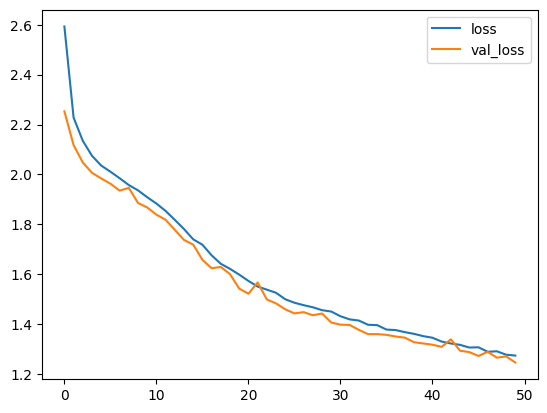

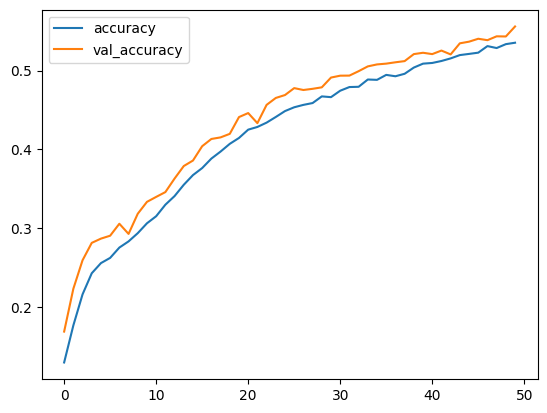

In [19]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

# Visualize the Latent Bottleneck

In [20]:
images, labels = next(iter(test_ds))

# Set the flag for attn score
model.rnn.cell.get_attn_scores = True
outputs = model(images)

In [21]:
# Grab the list of chunk scores
list_chunk_scores = model.rnn.cell.attn_scores

In [22]:
def score_to_viz(chunk_score):
    chunk_viz = tf.math.reduce_max(chunk_score, axis=-2) # get the most attended token
    chunk_viz = tf.math.reduce_mean(chunk_viz, axis=1) # get the mean across heads
    return chunk_viz

In [23]:
list_chunk_viz = [score_to_viz(x) for x in list_chunk_scores]

In [24]:
chunk_viz = tf.concat(list_chunk_viz[1:], axis=-1)
chunk_viz = tf.reshape(
    chunk_viz,
    (BATCH_SIZE, IMAGE_SIZE//PATCH_SIZE, IMAGE_SIZE//PATCH_SIZE, 1)
)

In [25]:
upsampled_heat_map = layers.UpSampling2D(
    size=(4, 4),
    interpolation='bilinear'
)(chunk_viz)

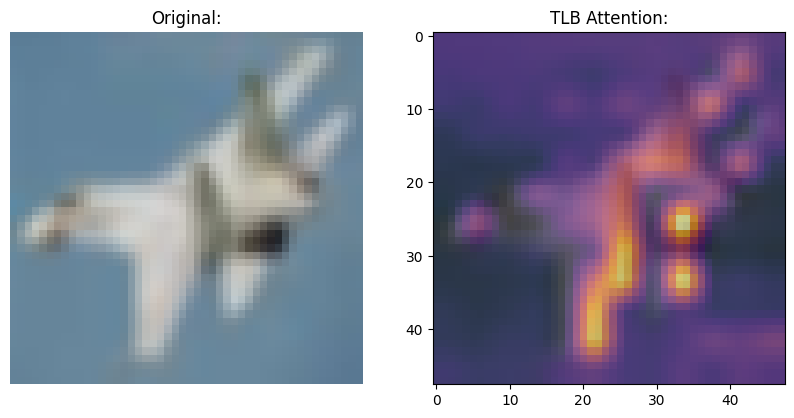

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

index = 10
orig_image = images[index]
overlay_image = upsampled_heat_map[index, ..., 0]

ax[0].imshow(orig_image)
ax[0].set_title("Original:")
ax[0].axis("off")

image = ax[1].imshow(orig_image)
ax[1].imshow(
    overlay_image,
    cmap="inferno",
    alpha=0.6,
    extent=image.get_extent()
)
ax[1].set_title("TLB Attention:")

plt.show()

# Save the model

In [27]:
model.summary()

Model: "model_trainer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patch_embed (PatchEmbed)    multiple                  12480     
                                                                 
 rnn (RNN)                   multiple                  502400    
                                                                 
 global_average_pooling1d (G  multiple                 0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_20 (Dense)            multiple                  650       
                                                                 
Total params: 515,530
Trainable params: 515,530
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.save_weights("50_epoch.ckpt")

# Load the model back

In [29]:
keras.backend.clear_session()

# PATCH
patch_layer = PatchEmbed(
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    patch_size=(PATCH_SIZE, PATCH_SIZE),
    embed_dim=EMBED_DIM,
    chunk_size=CHUNK_SIZE,
)

# RECURRENCE
cell = CustomCell(
    chunk_size=CHUNK_SIZE,
    r=R,
    num_layers=NUM_LAYERS,
    ffn_dims=EMBED_DIM,
    ffn_dropout=FFN_DROP, 
    num_heads=NUM_HEADS,
    key_dim=EMBED_DIM,
    attn_dropout=ATTN_DROP,
)


model_temp = ModelTrainer(patch_layer, cell)
model_temp.load_weights("50_epoch.ckpt")

In [30]:
images, labels = next(iter(test_ds))

# Set the flag for attn score
model_temp.rnn.cell.get_attn_scores = True
outputs = model_temp(images)

In [31]:
# Grab the list of chunk scores
list_chunk_scores = model_temp.rnn.cell.attn_scores

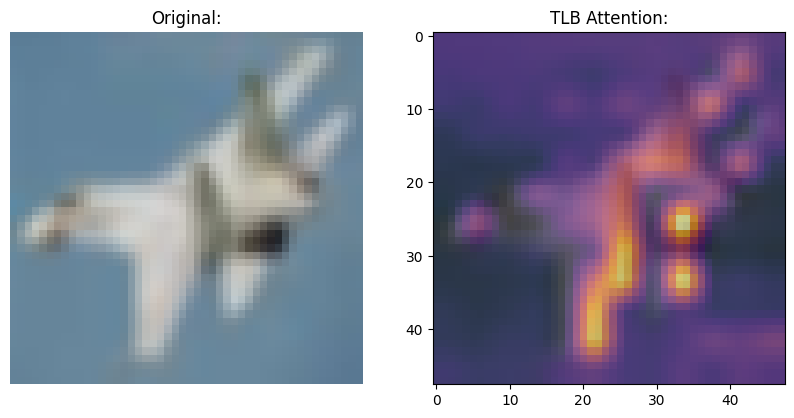

In [32]:
def score_to_viz(chunk_score):
    chunk_viz = tf.math.reduce_max(chunk_score, axis=-2) # get the most attended token
    chunk_viz = tf.math.reduce_mean(chunk_viz, axis=1) # get the mean across heads
    return chunk_viz

list_chunk_viz = [score_to_viz(x) for x in list_chunk_scores]
chunk_viz = tf.concat(list_chunk_viz[1:], axis=-1)
chunk_viz = tf.reshape(
    chunk_viz,
    (BATCH_SIZE, IMAGE_SIZE//PATCH_SIZE, IMAGE_SIZE//PATCH_SIZE, 1)
)
upsampled_heat_map = layers.UpSampling2D(
    size=(4, 4),
    interpolation='bilinear'
)(chunk_viz)

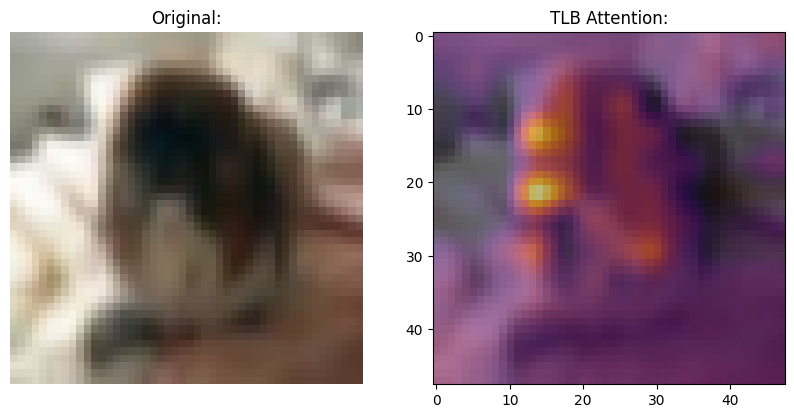

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

index = 200
orig_image = images[index]
overlay_image = upsampled_heat_map[index, ..., 0]

ax[0].imshow(orig_image)
ax[0].set_title("Original:")
ax[0].axis("off")

image = ax[1].imshow(orig_image)
ax[1].imshow(
    overlay_image,
    cmap="inferno",
    alpha=0.6,
    extent=image.get_extent()
)
ax[1].set_title("TLB Attention:")

plt.show()